In [1]:
from rich.pretty import pprint

def pretty_print(title: str = None, content: str = None):
    if title is None:
        print(content)
        return
    print(title)
    pprint(content)

## Image for use

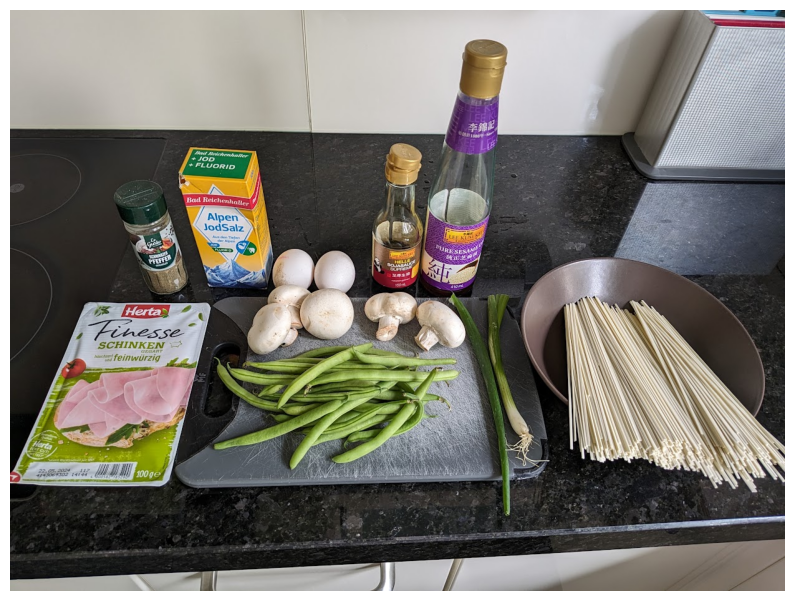

In [2]:
import matplotlib.pyplot as plt

image_path = "tmp/PXL_20240519_091911801.jpg"
import urllib.request

url = "https://dl.dropbox.com/scl/fi/fvpgpwzlqa8v3j6ntis2s/PXL_20240519_091911801.jpg?rlkey=vtc5dakept5jku8klknfaa150"
urllib.request.urlretrieve(url, image_path)

# no axis
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(image_path))

## Method

- Use the multi-modal model to create a row of accurate ground truth labels, known as `gt`, for object detection in the image.
    - Use the multi-modal model to generate a detailed description of the image.
    - Use the multi-modal model to derive object labels from the image description, utilizing a COCO dataset label for standard.
- To enhance the dynamic power of the multi-model in generating varied image descriptions, we raise the model's `temperature`.
- Use the `gt` to occhastrate the open-vocabulary models to detect objects in the image.
- Because the open-vocabulary models can only detect the objects that the `gt` has identified, we employ the proper metircs to compare the performance of the open-vocabulary models with the `gt`.
- We perform serveral above steps repeatedly, denoting `N_repeats`, so `N_repeat` groups of `gt` and run the open-vocabulary models on each group.

## Metrics

We employ a multi-modal model to ochastrate an open-vocabulary models for object detection to compare the performance of those.

The open-vocabulary models depend on the multi-modal model to first detect objects. In order to evaluate the performance of the open-vocabulary models, we assess its accuracy by comparing the percentage of detections from the ground truth (`gt`) determined by the multi-modal model with the predictions (`pred`) generated by the open-vocabulary models.

In [3]:
class Metrics:
    gt: list[str]
    pred: list[str]

    def __init__(self, gt: list[str], pred: list[str]):
        self.gt = set(gt)
        self.pred = set(pred)

        #pretty_print("Ground truth", self.gt)
        #pretty_print("Prediction", self.pred)

    def accuracy(self) -> float:
        acc = len(self.pred.intersection(self.gt)) / len(self.gt)
        return round(acc, 3)

    @property
    def __str__(self) -> str:
        return f"Accuracy: {self.accuracy()}"

## Generate the ground truth labels

- GPT-4o: Generate the image description, also `Anthropic` can be a good choice.
- GPT-3.5: Generate the labels based on the image description, COCO format.

In [4]:
N_repeats = 100
temperature = 0.8

In [5]:
# If no keys to OpenAI or other providers, just try the following labels.

# coco_labels = [
#    'cutting board, green beans, mushrooms, green onion, brown bowl, noodles, packet, ham, green pepper grinder, box, iodized salt, eggs, bottle, soy sauce, bottle, sesame oil',
#    'container, pepper, salt, egg, bottle, cutting board, beans, mushroom, onion, bowl, noodle',
#    'ham, pepper, salt, egg, soy sauce, sesame oil, green beans, mushrooms, green onions, noodles',
#    'food, bottle, box, egg, sauce, oil, green bean, mushroom, onion, cutting board, bowl, noodle',
#    'food, bottle, bowl, egg, container, packet, box, cutting board, beans, mushrooms, onions, noodles',
#    'bowl, bottle, pepper, egg, board, onion, mushroom, bean, bottle, salt, packet',
#    'countertop, ingredients, ham, pepper, salt, eggs, soy sauce, sesame oil, cutting board, green beans, mushrooms, green onions, bowl, noodles',
#    'bottle, bowl, box, cutting board, egg, green pepper, ham, mushroom, noodle, salt, soy sauce',
#    'bottle, bowl, box, cutting board, egg, green pepper, mushroom, noodles, packet, salt, shaker',
#    'bottle,bowl,container,egg,food,ingredient,knife,person,plate,pot,table',
#    'food, egg, bottle, bowl, mushroom, onion, container, board, bean, salt',
#    'bottle, bowl, box, counter, egg, bottle, pepper, salt, mushroom, onion, board, bean',
#    'bowl, bottle, box, pepper, egg, onion, mushroom, cutting board, bottle, beans, salt, ham',
#    'bottle,bowl,container,egg,food,fruit,kitchen,knife,person,plate,pot,vegetable',
#    'vegetable, bottle, pepper, egg, bowl, bottle, mushroom, board, onion, sauce, bean, salt',
#    'egg, bottle, bowl, pepper, board, mushroom, onion, bean, packet, box',
#    'bottle,bowl,container,egg,food,vegetable,onion,board,mushroom,salt,pepper',
#    'food, ham, pepper, salt, egg, soy sauce, sesame oil, green beans, mushroom, green onion, cutting board, noodle',
#    'bowl, bottle, box, counter, cutting board, egg, food, ingredient, mushroom, pepper, salt, soy sauce',
#    'countertop, food, bottle, egg, mushroom, green onion, cutting board, pepper, bowl',
#    'container, pepper, salt, egg, bottle, sauce, oil, bean, mushroom, onion, cutting board, bowl, noodle',
#   'bottle,bowl,box,packet,shaker,green pepper,ham,iodized salt,sesame oil,soy sauce,egg,green bean,mushroom,green onion,noodle',
#    'food, bottle, bowl, egg, bottle, container, box, board, beans, noodles, mushrooms, onions',
#    'bottle,bowl,box,egg,food,vegetable,onion,mushroom,salt,pepper,bean',
#    'food, ham, pepper, salt, egg, soy sauce, sesame oil, green beans, mushroom, green onion, cutting board, bowl, noodle',
#    'counter, ingredients, ham, pepper shaker, salt, eggs, soy sauce, sesame oil, green beans, mushrooms, green onions, cutting board, noodles',
#    'egg, bottle, bowl, mushroom, onion, cutting board, container, packet, box, beans',
#    'countertop, cooking items, ham, pepper shaker, salt, eggs, soy sauce, sesame oil, green beans, mushrooms, green onions, cutting board, noodles',
#    'bottle,bowl,container,egg,food,knife,packet,paper,vegetable',
#    'bottle,bowl,box,egg,food,vegetable,onion,mushroom,countertop,packet,salt,soy sauce,sesame oil,ham.',
#    'bottle,bowl,container,egg,food,fruit,kitchen,knife,mushroom,onion,person,plate,potato,tomato,vegetable'
# ]

## Multi-modal model: get image description

In [6]:
import base64
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage

 
def image_detector(
    image_path: str, n_repeat: int, temperature: float = 0.0
) -> str:
    """Detects objects in an image as much as possible and returns the description of the image."""
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
        chain = ChatOpenAI(model="gpt-4o", temperature=temperature, max_tokens=1024 * 2)
        #chain = chain.with_structured_output(ImageDescriptions)
        res = chain.invoke(
            [
                HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": f"""Give me {n_repeat} descriptions of the image returned in a list, splitted by a new line, no leading count number, no bulletpoints.
- Each desciption should be unique.
- The description should contain the description of the objects that you have understood.
- The desctiption should be as detailed as possible.""",
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                            },
                        },
                    ]
                )
            ]
        )

        return res

In [7]:
image_descriptions = image_detector(image_path, N_repeats, temperature)
image_descriptions = image_descriptions.content.split("\n")
image_descriptions = [x.strip() for x in image_descriptions if x.strip()]
pretty_print("Image descriptions", image_descriptions)

Image descriptions


[
│   'A variety of cooking ingredients are arranged on a kitchen countertop with a black, glossy surface.',
│   'A packet labeled "Herta Finesse Schinken" containing sliced ham is placed on the left side of the countertop.',
│   'Next to the packet of ham, there is a small, green-lidded container of ground black pepper.',
│   'A blue and yellow carton of iodized salt, labeled "Alpen JodSalz," is positioned near the pepper container.',
│   'Three brown mushrooms are scattered across a cutting board in the center of the image.',
│   'Next to the mushrooms are three white eggs, also on the cutting board.',
│   'A bundle of fresh green beans is placed on the cutting board, partially overlapping the mushrooms.',
│   'A single green onion with long green stalks and white roots is laid on the cutting board alongside the green beans.',
│   'On the right side, there is a bottle of soy sauce with a dark label and golden cap.',
│   'A larger bottle of Lee Kum Kee pure sesame oil, with a purple label and golden cap, stands next to the soy sauce.',
│   'In the foreground, a large, brown mixing bowl is filled with uncooked noodles.',
│   'The countertop is part of a modern kitchen, and the background features a stovetop and kitchen cabinets.',
│   'The cutting board is rectangular and appears to be made of a gray, plastic material.',
│   'The noodles in the bowl look like thin spaghetti or Asian-style noodles, perhaps soba or udon.',
│   'The black pepper container has a green lid and white text on the label.',
│   'The salt carton has a blue section with white text and a yellow section with red text.',
│   'The ham package shows an image of sliced ham with some green herbs, likely parsley.',
│   'The soy sauce bottle has a dark label with red and gold accents, and some Asian characters.',
│   'The sesame oil bottle is taller and has a golden cap with a purple label featuring Asian scripts.',
│   'The mushrooms appear to be button mushrooms, with a smooth, rounded cap and short stems.',
│   'The green beans are fresh and vibrant, with some of them overlapping each other.',
│   'The green onion has a long, white base with thin, green stalks extending upwards.',
│   'The mixing bowl is deep and brown, with a matte surface.',
│   'The eggs have a smooth, white shell and are placed casually on the cutting board.',
│   "The countertop's black surface reflects some of the light, giving a shiny appearance.",
│   'The kitchen has a minimalist design with white walls and clean lines.',
│   'A section of the stovetop, which appears to be an electric cooktop, is visible on the left.',
│   'The soy sauce and sesame oil bottles are positioned close together, suggesting they might be used together in a recipe.',
│   'The entire setup appears to be prepared for making a meal, possibly an Asian-inspired dish.',
│   'The black cutting board contrasts with the green vegetables and white mushrooms.',
│   'The ham slices in the packet are light pink and thinly sliced.',
│   'The green beans are neatly arranged, with some curving slightly.',
│   'The eggs have a slight shine, indicating their freshness.',
│   'The kitchen background is blurred, keeping the focus on the ingredients in the foreground.',
│   'The mushrooms have a slightly rough texture on their caps.',
│   "The green onion's roots are intact, indicating it’s fresh.",
│   'The soy sauce bottle has a transparent body, showing the dark liquid inside.',
│   'The sesame oil bottle is also transparent, showing the golden-colored oil.',
│   'The countertop has a small white section in the background, possibly part of the backsplash.',
│   'The cutting board has a slight texture, typical for a plastic cutting board.',
│   'The noodles are long and straight, neatly placed in the bowl.',
│   'The ground black pepper container has a slightly curved shape, easy to grip.',
│   'The iodized salt carton has a spout at the top for easy pouring.',
│   'The entire setup is well-lit, likely by natural light from a 

## Multi-modal model: get labels from the image descriptions

In [8]:
from langchain.prompts.chat import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def coco_label_extractor(img_desc_list: list[str], temperature: float) -> str:
    """Read an image description and extract COCO defined labels as much as possible from the description."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You as an AI assistant can understand an image descritpion. 
                 Try to extract COCO defined labels as much as possible from the description.
                 Only return lables and split by comma, no empty space between labels.""",
            ),
            ("human", "Image descritpion: {img_desc}"),
        ]
    )
    model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=2028)
    chain = prompt | model | StrOutputParser()
    return chain.batch(img_desc_list)

In [9]:
coco_labels = coco_label_extractor(image_descriptions, temperature)
pretty_print("coco_labels", coco_labels)

coco_labels


[
│   'food, fruit, vegetable, bowl, knife, cutting board, kitchen, countertop',
│   'packet, ham, countertop',
│   'packet, container, pepper',
│   'carton,salt,pepper\tcontainer',
│   'mushroom,cutting board',
│   'mushroom, egg, cutting board',
│   'vegetable, food, green beans, mushrooms, cutting board',
│   'vegetable, onion, green, cutting board, green beans',
│   'bottle, label, cap',
│   'bottle, oil, label, cap',
│   'bowl,noodles',
│   'countertop,kitchen,cabinets,stovetop',
│   'cutting board, rectangle, plastic',
│   'food,dish,bowl,noodles,spaghetti,soba,udon',
│   'container,lid,text',
│   'container, text, blue, white, yellow, red',
│   'food, meat, herb',
│   'bottle,label,red,gold,Asian_characters',
│   'bottle, cap, label',
│   'mushroom',
│   'vegetable, food, green bean',
│   'vegetable, plant, green onion',
│   'bowl, surface',
│   'egg,cutting board',
│   'countertop, surface, light',
│   'indoor, wall, kitchen',
│   'stove, cooktop',
│   'bottle,sauce',
│   'food, bowl, plate, table',
│   'cutting board, vegetables, mushrooms',
│   'food, ham',
│   'vegetable, food, green bean',
│   'egg',
│   'kitchen, ingredients',
│   'mushroom',
│   'plant, vegetable, food',
│   'bottle, liquid',
│   'bottle,oil',
│   'countertop, white, backsplash',
│   'cutting board, texture, plastic',
│   'food,dish,bowl',
│   'container, pepper',
│   'container,bottle',
│   'window, indoor',
│   'kitchen, clutter',
│   'food, ham, packet, window, slices',
│   'green beans, vegetables',
│   'mushroom',
│   'vegetable, onion, cutting board',
│   'egg',
│   'bowl,noodles',
│   'countertop, surface',
│   'bottle,label,English,Asian',
│   'bottle, label',
│   'food, packet, ham',
│   'vegetable, food',
│   'mushroom',
│   'plant,onion',
│   'egg,cutting board',
│   'cutting board, vegetables, mushrooms',
│   'food, noodles',
│   'container, pepper',
│   'container, box',
│   'bottle, soy sauce',
│   'bottle,oil',
│   'stove, burner, cooktop',
│   'countertop,eggs,mushrooms',
│   'cutting board',
│   'food, pasta',
│   'container, pepper, seal, plastic',
│   'container,paper',
│   'food, ham, packet',
│   'vegetable, food',
│   'mushroom',
│   'vegetable, plant, food',
│   'egg,cutting board',
│   'bowl, mixing, ingredients',
│   'countertop, light, ingredients',
│   'kitchen, indoor',
│   'container, pepper, salt, carton',
│   'label, packet, green',
│   'mushroom',
│   'vegetable, green bean, cutting board',
│   'plant,onion',
│   'eggs, composition',
│   'bowl,countertop',
│   'bottle',
│   'bottle',
│   'countertop, reflective'
]

# Open-vocabulary models

In [10]:
from typing import Any


class OpenVocModel:
    def predict(self, image_path: str, pred_classes: list[str]) -> tuple[Any, Metrics]:
        raise NotImplementedError

    def save(self, path: str) -> str:
        raise NotImplementedError

## YOLO8 World

In [11]:
from ultralytics import YOLO
from ultralytics.engine.results import Boxes, Results


class YoLoVocModel(OpenVocModel):
    _res: Any

    def predict(
        self, image_path: str, pred_classes: list[str]
    ) -> tuple[Results, Metrics]:
        model = YOLO(
            "yolov8s-world.pt"
        )  # or select yolov8m/l-world.pt for different sizes

        if len(pred_classes):
            model.set_classes(pred_classes)

        preds = model.predict(image_path)
        results: Results = preds[0]
        cls = results.boxes.cls.cpu().numpy().tolist()
        cls = [int(c) for c in cls]
        # Find predicted class-ids to map back into class names
        label_names = results.names
        selected_names = [label_names[i] for i in cls]
        self._res = results
        return results, Metrics(pred_classes, selected_names)

    def save(self, path: str) -> str:
        return self._res.save(path)
    
yolo_model = YoLoVocModel()

### Try


c:\Users\I804028\AppData\Local\miniconda3\envs\machinelearning\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)



image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 1 bowl, 1 cutting board, 1 kitchen, 1 countertop, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)
results


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'food', 1: 'fruit', 2: 'vegetable', 3: 'bowl', 4: 'knife', 5: 'cutting board', 6: 'kitchen', 7: 'countertop'}
obb: None
orig_img: array([[[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 17,  15,  15],
│   │   [ 14,  13,  15],
│   │   [ 11,  13,  14]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 28,  26,  26],
│   │   [ 26,  25,  27],
│   │   [ 25,  27,  28]],
│      
│      [[178, 187, 191],
│   │   [178, 187, 191],
│   │   [178, 187, 191],
│   │   ...,
│   │   [ 21,  21,  21],
│   │   [ 22,  24,  24],
│   │   [ 26,  28,  28]],
│      
│      ...,
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]],
│      
│      [[154, 164, 164],
│   │   [155, 165, 165],
│   │   [157, 167, 167],
│   │   ...,
│   │   [114, 123, 136],
│   │   [114, 123, 136],
│   │   [114, 123, 136]]], dtype=uint8)
orig_shape: (932, 1243)
path: 'c:\\Users\\I804028\\Desktop\\dev\\chat-your-doc\\tmp\\PXL_20240519_091911801.jpg'
probs: None
save_dir: 'runs\\detect\\predict'
speed: {'preprocess': 1.9998550415039062, 'inference': 72.99971580505371, 'postprocess': 14.999866485595703}

results.bboxes


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 7., 3., 6.], device='cuda:0')
conf: tensor([0.8263, 0.5301, 0.4213, 0.3760], device='cuda:0')
data: tensor([[2.6308e+02, 4.5181e+02, 8.4595e+02, 7.6807e+02, 8.2631e-01, 5.0000e+00],
│   │   [2.7094e+00, 1.9442e+02, 1.2430e+03, 8.8441e+02, 5.3006e-01, 7.0000e+00],
│   │   [8.1550e+02, 3.9757e+02, 1.2140e+03, 6.5317e+02, 4.2128e-01, 3.0000e+00],
│   │   [2.3463e+00, 1.5039e+00, 1.2417e+03, 8.9396e+02, 3.7602e-01, 6.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (932, 1243)
shape: torch.Size([4, 6])
xywh: tensor([[ 554.5192,  609.9395,  582.8683,  316.2613],
│   │   [ 622.8547,  539.4109, 1240.2906,  689.9899],
│   │   [1014.7629,  525.3702,  398.5267,  255.5999],
│   │   [ 622.0162,  447.7343, 1239.3398,  892.4609]], device='cuda:0')
xywhn: tensor([[0.4461, 0.6544, 0.4689, 0.3393],
│   │   [0.5011, 0.5788, 0.9978, 0.7403],
│   │   [0.8164, 0.5637, 0.3206, 0.2742],
│   │   [0.5004, 0.4804, 0.9971, 0.9576]], device='cuda:0')
xyxy: tensor([[ 263.0850,  451.8088,  845.9533,  768.0701],
│   │   [   2.7094,  194.4160, 1243.0000,  884.4059],
│   │   [ 815.4995,  397.5703, 1214.0262,  653.1702],
│   │   [   2.3463,    1.5039, 1241.6862,  893.9648]], device='cuda:0')
xyxyn: tensor([[0.2117, 0.4848, 0.6806, 0.8241],
│   │   [0.0022, 0.2086, 1.0000, 0.9489],
│   │   [0.6561, 0.4266, 0.9767, 0.7008],
│   │   [0.0019, 0.0016, 0.9989, 0.9592]], device='cuda:0')

metrics


'Accuracy: 0.5'

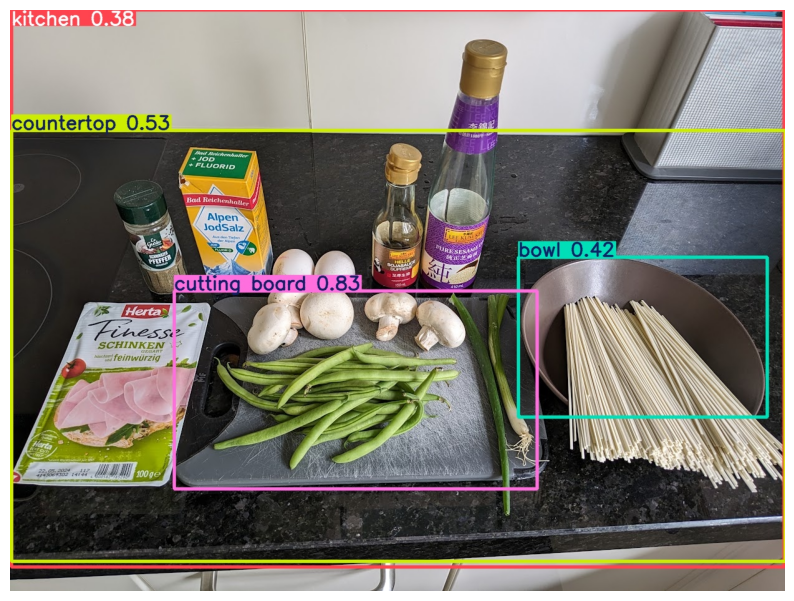

In [12]:
coco_label_list = coco_labels[0].split(",")
coco_label_list = [label.strip() for label in coco_label_list] 

res, metrics = yolo_model.predict(pred_classes=coco_label_list, image_path=image_path)
pretty_print("results", res)
pretty_print("results.bboxes", res.boxes)
pretty_print("metrics", metrics.__str__)

path = "tmp/yolo8world_try.jpg"
save_1 = yolo_model.save(path)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(path))

## GroundingDINO

In [13]:
import torch
from PIL import Image
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

import numpy as np
import supervision as sv


class GroundingDINO(OpenVocModel):
    box_threshold: float = 0.32
    text_threshold: float = 0.32
    _image: Image.Image
    _res: Any
    _pred_classes: list[str]

    def predict(
        self,
        image_path: str,
        pred_classes: list[str],
    ) -> tuple[Any, Metrics]:
        self._image = Image.open(image_path)
        caption = ". ".join(pred_classes) + "." if pred_classes else ""
        model_id = "IDEA-Research/grounding-dino-base"
        device = "cuda" if torch.cuda.is_available() else "cpu"
        processor = AutoProcessor.from_pretrained(model_id)
        model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
        inputs = processor(
            images=self._image,
            text=caption,
            return_tensors="pt",
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            results = processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                box_threshold=self.box_threshold,
                text_threshold=self.text_threshold,
                target_sizes=[self._image.size[::-1]],
            )
            ret = results[0]
            self._res = ret
            self._pred_classes = pred_classes
            return ret, Metrics(pred_classes, ret["labels"])

    def save(self, path: str):
        res_labels = self._res["labels"]

        def class2id(classes: list[str], res_labels: list[str]) -> np.ndarray:
            return np.array([classes.index(label) for label in res_labels])

        confidence = self._res["scores"].cpu().detach().numpy()
        detections = sv.Detections(
            xyxy=self._res["boxes"].cpu().detach().numpy(),
            confidence=confidence,
            class_id=class2id(self._pred_classes, res_labels),
        )
        bbox_annotator, label_annotator = sv.BoundingBoxAnnotator(
            color=sv.ColorPalette.ROBOFLOW
        ), sv.LabelAnnotator(color=sv.ColorPalette.ROBOFLOW)
        annotated_image = label_annotator.annotate(
            bbox_annotator.annotate(
                self._image.copy(),
                detections=detections,
                custom_color_lookup=sv.ColorLookup.CLASS,
            ),
            detections=detections,
            labels=[
                label + " " + str(round(score, 2))
                for label, score in zip(res_labels, confidence)
            ],
            custom_color_lookup=sv.ColorLookup.CLASS,
        )
        annotated_image.save(path)
        return path
    
grounding_dino = GroundingDINO()

c:\Users\I804028\AppData\Local\miniconda3\envs\machinelearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Try

results


{
│   'scores': tensor([0.4768, 0.5201, 0.5323, 0.3334, 0.3966, 0.3808, 0.5665, 0.3781, 0.3691, 0.4623, 0.4298, 0.3582, 0.3746, 0.3737, 0.3373, 0.3745, 0.3646], device='cuda:0'),
│   'labels': [
│   │   'food',
│   │   'countertop',
│   │   'bowl',
│   │   'food',
│   │   'food',
│   │   'food',
│   │   'vegetable',
│   │   'food',
│   │   'food',
│   │   'kitchen',
│   │   'cutting board',
│   │   'food',
│   │   'food',
│   │   'vegetable',
│   │   'food',
│   │   'vegetable',
│   │   'vegetable'
│   ],
│   'boxes': tensor([[6.9464e+01, 5.6816e+02, 2.9819e+02, 7.0420e+02],
│   │   [1.8930e-01, 1.9212e+02, 1.2431e+03, 9.2149e+02],
│   │   [8.1725e+02, 3.9548e+02, 1.2132e+03, 6.5501e+02],
│   │   [3.7941e+02, 3.8191e+02, 5.5586e+02, 5.5406e+02],
│   │   [3.2601e+02, 5.3255e+02, 7.2137e+02, 7.3776e+02],
│   │   [4.8723e+02, 3.8507e+02, 5.5499e+02, 4.5369e+02],
│   │   [3.2564e+02, 5.3321e+02, 7.2210e+02, 7.3746e+02],
│   │   [6.4817e+02, 4.6478e+02, 7.3182e+02, 5.4839e+02],
│   │   [4.1940e+02, 3.8235e+02, 4.8858e+02, 4.4858e+02],
│   │   [1.6940e-01, 1.2477e+00, 1.2429e+03, 9.2875e+02],
│   │   [2.6402e+02, 4.5270e+02, 8.6239e+02, 7.7493e+02],
│   │   [4.6433e+02, 4.4602e+02, 5.5316e+02, 5.2963e+02],
│   │   [5.6718e+02, 4.5106e+02, 6.5372e+02, 5.3206e+02],
│   │   [7.6433e+02, 4.5428e+02, 8.4316e+02, 7.3345e+02],
│   │   [3.7985e+02, 4.6869e+02, 4.6772e+02, 5.5386e+02],
│   │   [8.1497e+01, 5.5894e+02, 1.2265e+02, 5.9248e+02],
│   │   [7.0349e+02, 4.5325e+02, 8.0486e+02, 8.1059e+02]], device='cuda:0')
}

metrics


0.75

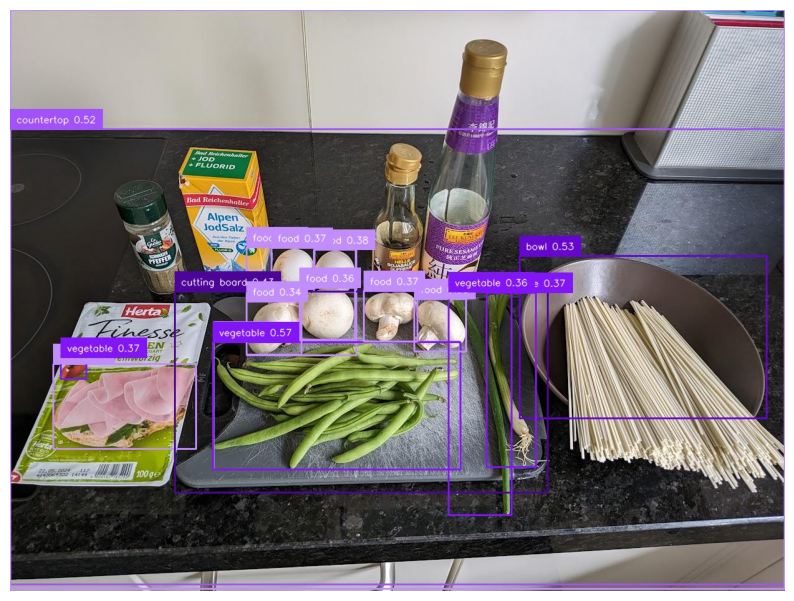

In [14]:
coco_label_list = coco_labels[0].split(",")
coco_label_list = [label.strip() for label in coco_label_list] 

res, metrics = grounding_dino.predict(
    image_path=image_path, pred_classes=coco_label_list
)
pretty_print("results", res)
pretty_print("metrics", metrics.accuracy())

path = "tmp/groundingDINO_try.jpg"
save_1 = grounding_dino.save(path)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(plt.imread(path))

## Survey

In [15]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [16]:
final_result_dict = dict()
final_result_dict["YOLOv8 World"] = list()
final_result_dict["GroundingDINO"] = list()


def do_survey(coco_label: str):
    coco_label_list = coco_label.split(",")
    coco_label_list = [label.strip() for label in coco_label_list]

    _, metrics = yolo_model.predict(pred_classes=coco_label_list, image_path=image_path)
    final_result_dict["YOLOv8 World"].append(metrics.accuracy())
    _, metrics = grounding_dino.predict(
        image_path=image_path, pred_classes=coco_label_list
    )
    final_result_dict["GroundingDINO"].append(metrics.accuracy())


#asyncio.run(asyncio.gather(*[do_survey(coco_label) for coco_label in coco_labels]))
for coco_label in coco_labels:
    do_survey(coco_label)


image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 1 bowl, 1 cutting board, 1 kitchen, 1 countertop, 22.0ms
Speed: 2.0ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 1 countertop, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 (no detections), 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\I804028\Desktop\dev\chat-your-doc\tmp\PXL_20240519_091911801.jpg: 480x640 1 cutting board, 1

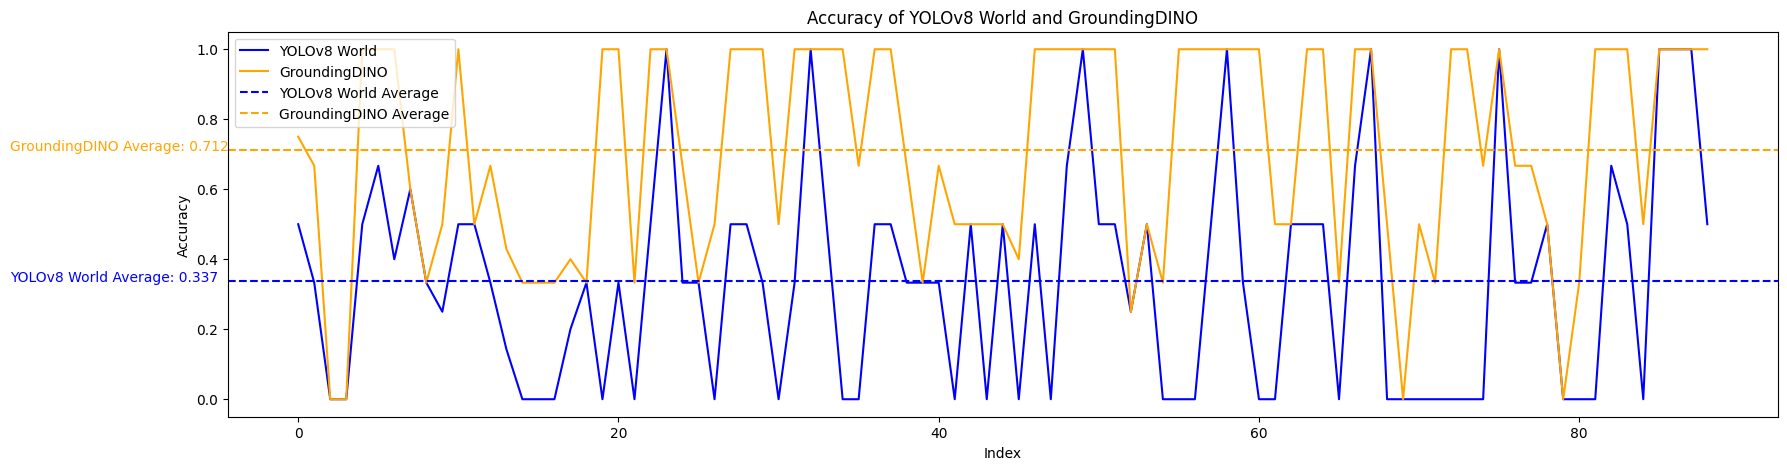

In [30]:
# plot the results

# average the results
average_result_dict = dict()
average_result_dict["YOLOv8 World"] = round(
    sum(final_result_dict["YOLOv8 World"]) / len(final_result_dict["YOLOv8 World"]), 3
)

average_result_dict["GroundingDINO"] = round(
    sum(final_result_dict["GroundingDINO"]) / len(final_result_dict["GroundingDINO"]), 3
)


# put average on the plot
plt.figure(figsize=(20, 5))
plt.plot(final_result_dict["YOLOv8 World"], color="blue", label="YOLOv8 World")
plt.plot(final_result_dict["GroundingDINO"], color="orange", label="GroundingDINO")
plt.axhline(
    average_result_dict["YOLOv8 World"],
    color="blue",
    linestyle="--",
    label="YOLOv8 World Average",
)
plt.axhline(
    average_result_dict["GroundingDINO"],
    color="orange",
    linestyle="--",
    label="GroundingDINO Average",
)
# put average value on each axhline
plt.text(
    -18,
    average_result_dict["YOLOv8 World"],
    f"YOLOv8 World Average: {average_result_dict['YOLOv8 World']}",
    color="blue",
)
plt.text(
    -18,
    average_result_dict["GroundingDINO"],
    f"GroundingDINO Average: {average_result_dict['GroundingDINO']}",
    color="orange",
)
plt.title("Accuracy of YOLOv8 World and GroundingDINO")
plt.xlabel("Index")
plt.ylabel("Accuracy")

plt.legend()
plt.show()